<a href="https://colab.research.google.com/github/dbamman/nlp23/blob/main/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Featurized Models for Sentiment Analysis

For this assignment, we provide an implementation of a simple binary classifier that will predict the sentiment of a movie review based on a group of original features -- provided by you! 

Before diving into any code, please read through the associated [PDF](https://github.com/dbamman/nlp23/blob/main/HW1/HW1.pdf) for an overview of the assignment and specific instructions on how to submit.

In [2]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [3]:
!python -m nltk.downloader punkt

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Intro: Gather Data + Create Classifier

#### Gather Data

Let's download the data we'll use for training and development, and also the data we'll make predictions with.

In [4]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/test.txt

--2023-01-31 03:56:14--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.06s   

2023-01-31 03:56:15 (22.7 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2023-01-31 03:56:15--  https://raw.githubusercontent.com/dbamman/nlp23/main/HW1/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.

In [5]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

#### Define Classifier class

Next, we've created a Binary Classifier. This class will let us learn the traits associated with positive and negatively classed movie reviews in order to make predictions on our test set.

In [6]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

#### Simple Classifier example

Let's create an initial classifier based on a really simple feature using a dictionary: 

* if the abstract contains the words "love" or "like", the `contains_positive_word` feature will fire, and 
* if it contains either "hate" or "dislike", the `contains_negative_word` will fire.  

Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words (the documentation for which can be found [here](https://www.nltk.org/api/nltk.tokenize.html)).

In [7]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data. 

Note the `L2_regularization_strength` parameter specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and `min_feature_count` specifies how many data points need to contain a feature for it to be passed into the model as a feature. Both are ways to prevent the model from overfitting and achieve higher performance.

In [8]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


So we've created a classifier. But is its accuracy score any good?  Let's calculate the accuracy of a "majority classifier" to provide some context. This determines the most-represented (majority) class in the training data, and then predicts every test point to be this class.

In [9]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


The feature we created in `simple_featurize`, evidently, doesn't have a whole lot of legs. In the next portion of the homework, you'll be designing a few features of your own in the hopes of achieving the highest accuracy possible.

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm **3 additional** distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data.

To show your work: describe your new features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words| Standard bag of words model learns associations between specific words and performance | 0.601
|Feature 1| I used stemming and stopwords to decrease the amount of unnecessary and redundant features that may poorly affect discriminatory ability, with a bag of words. After all, too many unnecessary features may lead to overfitting on the training set with logistic regression, which would impact validation performance. | 0.773
|Feature 2| Again this approach is similar to bag of words, but I was hoping for more detail in using a lexicon to assign values to the words; essentially moving away from the binary approach implemented in the first two exercises. Also, this lowers the total amount features in this phase, as only those with unique relevance to sentiment are present in the dictionary| 0.749
|Feature 3| I tried part of speech tagging using NLTK to see if the distribution of parts of speech differed from positive to negative; perhaps positive reviews focused on parts of the movies and more nouns while some negative reviews had more adjectives; It turned out there was some correlation.| 0.613

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment. Consider the type of data you are working with: what do you look for when writing/reading a movie review?

### Implement Bag-of-Words

In [22]:
# nltk.download('stopwords') # use first time
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    # BEGIN SOLUTION
    feats = {}
    for word in text:
        feats[word.lower()]=1
    return feats
    # END SOLUTION

In [23]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 89, Train accuracy: 0.649, Dev accuracy: 0.601


### Implement Original Features

In [69]:
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    feats = {}
    words = nltk.word_tokenize(text)
    stopword_list=nltk.corpus.stopwords.words('english')
    stopword_set = set(stopword_list)
    ps = nltk.PorterStemmer()
    for word in words:
      word = word.lower()
      if word not in stopword_set and word.isalpha():
        feats[ps.stem(word)]=1
    return feats

In [70]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 12076, Train accuracy: 1.000, Dev accuracy: 0.773


In [88]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    afinn_word_dict = {}
    with open("afinn.txt", encoding='UTF-8') as fid:
        for n, line in enumerate(fid):
            try:
                word, score = line.strip().split('\t')
            except ValueError:
                msg = 'Error in line %d of %s' % (n + 1, "afinn.txt")
                raise ValueError(msg)
            afinn_word_dict[word] = int(score)

    scores = []
    feats = {}
    words = nltk.word_tokenize(text)
    stopword_list=nltk.corpus.stopwords.words('english')
    stopword_set = set(stopword_list)
    for word in words:
      word = word.lower()
      if word not in stopword_set and word.isalpha():
        if word in afinn_word_dict:
          feats[f"{word}_afinn"] = afinn_word_dict[word]
    return feats

In [89]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 1804, Train accuracy: 0.994, Dev accuracy: 0.749


In [96]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    scores = []
    text = text.lower()
    words = nltk.word_tokenize(text)
    ps = nltk.PorterStemmer()
    tags = nltk.pos_tag(words)
    feats = Counter(tag for word, tag in tags)
    return feats

In [97]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 44, Train accuracy: 0.662, Dev accuracy: 0.613


## Deliverable 2

The two cells in "Combine your features" will generate a file named `combiner_function_predictions.csv`.

Download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 students with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

Please do not change the auto-generated filename!

### Combine your features

Next, let's combine any or all the features you have developed into one big model and make predictions on the test data. There is no exact number/threshold we're looking for, accuracy-wise, but the combiner function should *generally* have a higher accuracy than BoW on its own (assuming your features are adding additional information beyond what BoW is adding). 

You don't need to edit the following cell, unless you want to change which features are handed off to the "combined" model.

In [98]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    # at the moment, all 4 of: bag of words and your 3 original features are handed off to the combined model
    # update the values within [bag_of_words, feature1, feature2, feature3] to change this.
    
    all_feats={}
    for feature in [bag_of_words, feature1, feature2, feature3]:
        all_feats.update(feature(text))
    return all_feats

In [99]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 13989, Train accuracy: 1.000, Dev accuracy: 0.800


## Further Exploration: Interrogating classifiers

Note: No deliverables are in this section; it's optional. Treat this portion as a useful tool for further understanding the features you worked on and how they affter the classifier.

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels). What kinds of mistakes is it making? (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


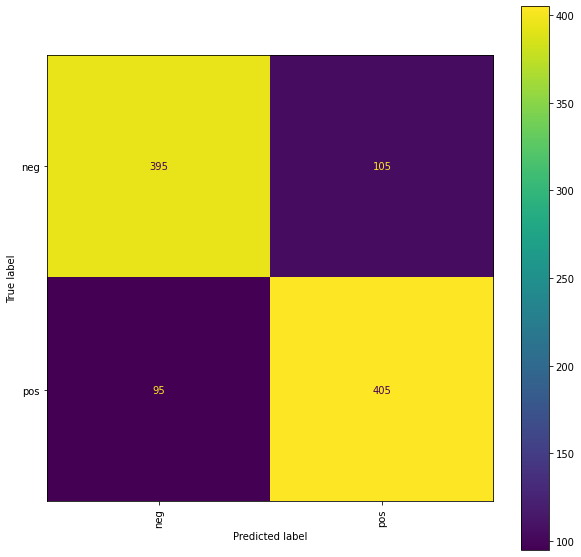

In [100]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most important for each of the classes (ranked by how strong their corresponding coefficient is). Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [101]:
big_classifier.printWeights(n=25)

pos	0.761	worst_afinn
pos	0.688	boring_afinn
pos	0.647	thought
pos	0.569	enjoyed_afinn
pos	0.534	awful_afinn
pos	0.528	stupid_afinn
pos	0.526	poorly_afinn
pos	0.524	horrible_afinn
pos	0.517	great_afinn
pos	0.505	gem_afinn
pos	0.497	worse_afinn
pos	0.493	seri
pos	0.493	relationship
pos	0.490	man
pos	0.486	poor_afinn
pos	0.480	move
pos	0.475	seen
pos	0.465	new
pos	0.459	sing
pos	0.448	human
pos	0.448	also
pos	0.444	fails_afinn
pos	0.439	wonderfully_afinn
pos	0.438	go
pos	0.433	simpl

neg	-0.658	act
neg	-0.566	?
neg	-0.559	noth
neg	-0.546	mayb
neg	-0.531	idea
neg	-0.530	EX
neg	-0.528	4
neg	-0.526	would
neg	-0.484	wast
neg	-0.465	bore
neg	-0.460	money
neg	-0.442	violence_afinn
neg	-0.440	tv
neg	-0.437	done
neg	-0.429	ask
neg	-0.423	slow
neg	-0.419	half
neg	-0.394	killer
neg	-0.388	foul_afinn
neg	-0.383	war_afinn
neg	-0.382	silli
neg	-0.381	brutal_afinn
neg	-0.379	offic
neg	-0.373	actor
neg	-0.373	someth



3. Next, let's look at the individual data points that are the hardest to classify correctly. Does it suggest any features you might create to disentangle them?

In [102]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [103]:
nalyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,1.000000,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1822,0.999983,pos,neg,"Zombi 3 has an interesting history in it's making. Firstly, it is a sequel to Fulci's hit Zombi 2, with Zombi 2 itself being of course a marketing ploy to trick people into thinking it was a sequel to George A. Romero's Dawn of the Dead aka Zombi. Confusing enough? Basically, none of the films have anything to do with one another, but who cares when they make money. I guess Fulci himself start..."
2,1178,0.999765,pos,neg,"While I do not think this was a perfect 10, I do agree it was way above a 6 which is what it's rated here. No, Brokedown Palace was not perfect and yes it's plot has been done many times before. That doesn't mean it shouldn't be done again if it is done well and I think this movie had some strong moments. The acting of Claire Danes, as already mentioned many times, was flawless as was Kate Bec..."
3,1670,0.999755,neg,pos,"I've always liked Fred MacMurray, andalthough her career was tragically cut shortI think Carole Lombard is fun to watch. Pair these two major and attractive stars together, add top supporting players like Jean Dixon, Anthony Quinn, Dorothy Lamour and Charles Butterworth, give them a romantic script, team them with noted director Mitchell Leisen and you get a mediocre movie experience.Skid Jo..."
4,1913,0.999642,neg,pos,"I have only seen Gretchen Mol in two other films (Girl 6, Donnie Brasco), and don't really remember her, but she did a great job as a naive girl who posed for pictures because it made people happy.She really didn't think what she was doing was wrong, even when she left the business and found her religion again.The photos she made were certainly tame by today's standards, and it is funny seeing..."
5,1309,0.999312,neg,pos,"Scooby Doo is undoubtedly one of the most simple, successful and beloved cartoon characters in the world. So, what happens when you've been everywhere and done everything with the formula? You switch it up right? Wrong. You stop production and let it rest for a decade or so and then run it again, keeping the core of its success intact. That is to say, stick with the formula for the most part b..."
6,1959,0.999233,pos,neg,"This is one of the best episode from the second season of MOH, I think Mick Garris has a problem with women... He kill'em all, they are often the victims (Screwfly solution, Pro-life, Valerie on the stairs, I don't remember the Argento's episode in season 1, etc., obviously Imprint). I think he enjoys to watch women been burn, torture, mutilated and I don't know. Never least ""Right to die"" is ..."
7,1938,0.999196,pos,neg,"All right, here's the deal: if you're easily offended then you might want to stay far, far away from this one. There are some painfully funny moments in the movie, but I probably blushed about as much as I laughed. Actually, I probably blushed MORE than I laughed. And if I wasn't literally blushing on the outside, then I was blushing on the inside. If there is absolutely nothing in this movie ..."
8,1784,0.999182,pos,neg,"The only complaint I have about this adaptation is that it is sexed-up. Things that were only hinted at in the novel are shown on-screen for some weird reason. Did they think the audience would be too stupid to understand if they were not shown everything out-right? Other than that, this is very good-quality. All the actors do marvelous jobs bringing their characters to life. For the shallow w..."
9,1110,0.998964,neg,pos,"Before Stan Laurel became the smaller half of the all-time greatest comedy team